In [ ]:
# installing packages (if required)
#!pip install pandas matplotlib statsmodels
#!pip install pmdarima

In [16]:
# importing packages
import pandas as pd
import io
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from google.colab import files
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

In [58]:
# reading in our daily data
uploaded = files.upload()

Saving df_daily.csv to df_daily.csv


In [62]:
daily_data = pd.read_csv(io.BytesIO(uploaded['df_daily.csv']), index_col='datetime', parse_dates=True)

In [72]:
# This function below with replace any 0 values in the specified column with the previous column's value in order to deal with "0" values

def replace_zeros_with_previous(df, column_name):
    for i in range(1, len(df)):
        if df[column_name].iloc[i] == 0:
            df[column_name].iloc[i] = df[column_name].iloc[i-1]
    return df

# Apply the function to your DataFrame
daily_data = replace_zeros_with_previous(daily_data, 'total_real_power')


<ipython-input-72-797aafdb38ea>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name].iloc[i] = df[column_name].iloc[i-1]


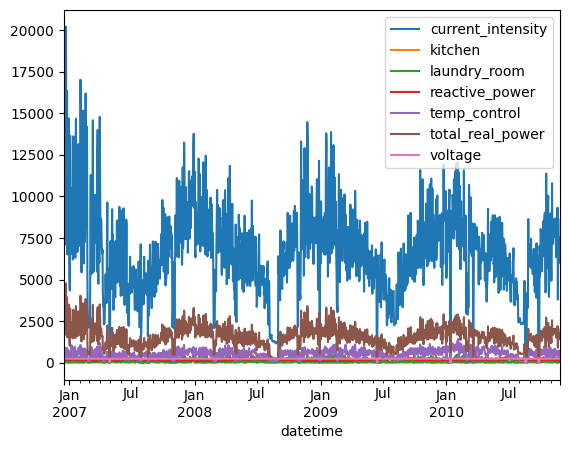

In [73]:
# Select all columns except 'Index' for plotting
columns_to_plot = daily_data.columns.difference(['index'])

# Plot the selected columns
daily_data[columns_to_plot].plot()
plt.show()


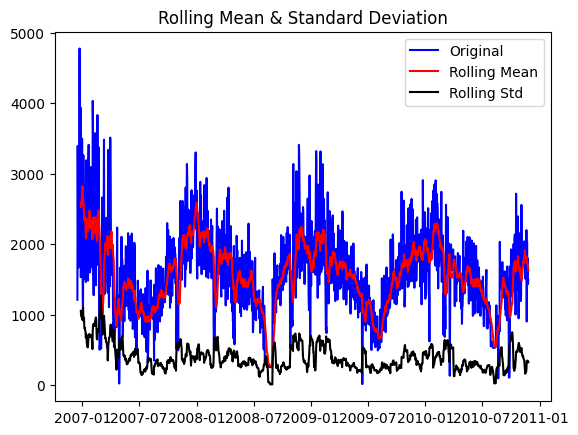

Results of Dickey-Fuller Test:
Test Statistic                   -3.823295
p-value                           0.002678
#Lags Used                       22.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -3.434967
Critical Value (5%)              -2.863579
Critical Value (10%)             -2.567856
dtype: float64


In [74]:
# Function to test stationarity
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(daily_data['total_real_power'])

In [76]:
# Define the training and testing dataset
train_size = int(len(daily_data) * 0.8)  # 80% of data for training
train, test = daily_data[0:train_size], daily_data[train_size:]

In [109]:
# Finding the best parameters for our ARIMA model
auto_model = auto_arima(train['total_real_power'],
                        seasonality=False,
                        suppress_warnings=True,
                        trace=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=17449.884, Time=4.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=18160.055, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17633.598, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=17782.577, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20445.370, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=17443.335, Time=3.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=17731.217, Time=0.69 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=17485.975, Time=1.42 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=17434.234, Time=3.97 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=17673.051, Time=1.71 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=17477.440, Time=2.55 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=17439.745, Time=2.69 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=17590.800, Time=1.17 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=17457.017, Time=3.02 sec
 ARIMA(1,0,3)(0,0,0

In [114]:
# Fit the ARIMA model on the training data using the best found parameters above

model=ARIMA(train['total_real_power'],order=(1,0,3))
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       total_real_power   No. Observations:                 1153
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -8711.276
Date:                Tue, 12 Dec 2023   AIC                          17434.552
Time:                        18:57:08   BIC                          17464.853
Sample:                    12-16-2006   HQIC                         17445.988
                         - 02-10-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1591.4013    141.393     11.255      0.000    1314.276    1868.527
ar.L1          0.9784      0.008    121.233      0.000       0.963       0.994
ma.L1         -0.6032      0.023    -25.700      0.000      -0.649      -0.557
ma.L2         -0.2729      0.028     -9.865      0.000      -0.327      -0.219
ma.L3          0.0894      0.024      3.764      0.000       0.043       0.136
sigma2      2.091e+05   6644.255     31.469      0.000    1.96e+05    2.22e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               284.11
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
# Now, we can make predictions on the test set

start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end, typ= 'levels')
print(pred)

2010-02-11    2118.436471
2010-02-12    2164.332312
2010-02-13    2133.442976
2010-02-14    2121.727506
2010-02-15    2110.265250
                 ...     
2010-11-22    1592.544085
2010-11-23    1592.519385
2010-11-24    1592.495219
2010-11-25    1592.471575
2010-11-26    1592.448442
Freq: D, Name: predicted_mean, Length: 289, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [120]:
min_value = daily_data['total_real_power'].min()
max_value = daily_data['total_real_power'].max()

print(f"Minimum value in 'total_real_power': {min_value}")
print(f"Maximum value in 'total_real_power': {max_value}")

Minimum value in 'total_real_power': 14.218
Maximum value in 'total_real_power': 4773.386


In [116]:
# Correct RMSE calculation
rmse = sqrt(mean_squared_error(test['total_real_power'], pred))
print('Test RMSE:', rmse)

Test RMSE: 528.5613411644044


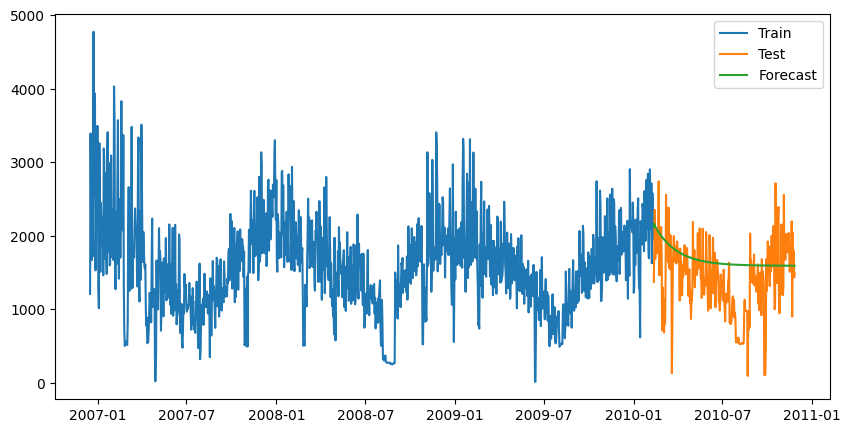

In [117]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['total_real_power'], label='Train')
plt.plot(test.index, test['total_real_power'], label='Test')
plt.plot(test.index, pred, label='Forecast')
plt.legend()
plt.show()

Now, let's take a quick look at the hourly ARIMA model.

In [121]:
# reading in our data
uploaded_2 = files.upload()

Saving df_hourly.csv to df_hourly (1).csv


In [122]:
hourly_data = pd.read_csv(io.BytesIO(uploaded_2['df_hourly (1).csv']), index_col='datetime', parse_dates=True)

In [123]:
hourly_data = replace_zeros_with_previous(hourly_data, 'total_real_power')

<ipython-input-72-797aafdb38ea>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name].iloc[i] = df[column_name].iloc[i-1]


In [124]:
# Define the training and testing dataset
train_size_hourly = int(len(hourly_data) * 0.8)  # 80% of data for training
train_hourly, test_hourly = hourly_data[0:train_size_hourly], hourly_data[train_size_hourly:]

In [126]:
# Finding the best parameters for our hourly ARIMA model
auto_model_hourly = auto_arima(train_hourly['total_real_power'],
                        seasonality=False,
                        suppress_warnings=True,
                        trace=True)

print(auto_model_hourly.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=279869.663, Time=64.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=285004.357, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=284902.606, Time=1.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=284866.598, Time=4.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=285002.358, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=31.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=35.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=44.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=46.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=18.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=53.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=57.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=279826.042, Time=86.11 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=97.59 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=279775.93

In [127]:
# Fit the ARIMA model on the training data using the best found parameters above

model_hourly=ARIMA(train_hourly['total_real_power'],order=(4,1,5))
model_fit_hourly=model_hourly.fit()
model_fit_hourly.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       total_real_power   No. Observations:                27671
Model:                 ARIMA(4, 1, 5)   Log Likelihood             -138854.169
Date:                Tue, 12 Dec 2023   AIC                         277728.338
Time:                        19:40:01   BIC                         277810.619
Sample:                    12-16-2006   HQIC                        277754.840
                         - 02-11-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3370      0.007    192.658      0.000       1.323       1.351
ar.L2          0.2849      0.010     29.036      0.000       0.266       0.304
ar.L3         -1.4355      0.009   -155.172      0.000      -1.454      -1.417
ar.L4          0.6009      0.007     92.080      0.000       0.588       0.614
ma.L1         -1.6507      0.008   -198.145      0.000      -1.667      -1.634
ma.L2         -0.1264      0.016     -7.699      0.000      -0.159      -0.094
ma.L3          1.7102      0.011    152.818      0.000       1.688       1.732
ma.L4         -0.8617      0.014    -63.495      0.000      -0.888      -0.835
ma.L5         -0.0697      0.007     -9.522      0.000      -0.084      -0.055
sigma2      1307.6927      6.710    194.900      0.000    1294.542    1320.843
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):             18701.02
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [128]:
# Now, we can make predictions on the test set

start_hourly = len(train_hourly)
end_hourly = len(train_hourly) + len(test_hourly) - 1
pred_hourly = model_fit_hourly.predict(start=start_hourly, end=end_hourly, typ= 'levels')
print(pred_hourly)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2010-02-11 16:00:00     41.486114
2010-02-11 17:00:00     66.661076
2010-02-11 18:00:00     91.393830
2010-02-11 19:00:00    113.330198
2010-02-11 20:00:00    126.176784
                          ...    
2010-11-26 17:00:00     93.901833
2010-11-26 18:00:00     97.286187
2010-11-26 19:00:00     99.019292
2010-11-26 20:00:00     98.637468
2010-11-26 21:00:00     96.244026
Freq: H, Name: predicted_mean, Length: 6918, dtype: float64


In [129]:
min_value_hourly = hourly_data['total_real_power'].min()
max_value_hourly = hourly_data['total_real_power'].max()

print(f"Minimum value in 'total_real_power': {min_value_hourly}")
print(f"Maximum value in 'total_real_power': {max_value_hourly}")

Minimum value in 'total_real_power': 1.776
Maximum value in 'total_real_power': 393.632


In [130]:
# Correct RMSE calculation
rmse_hourly = sqrt(mean_squared_error(test_hourly['total_real_power'], pred_hourly))
print('Test RMSE:', rmse_hourly)

Test RMSE: 53.589623648562586


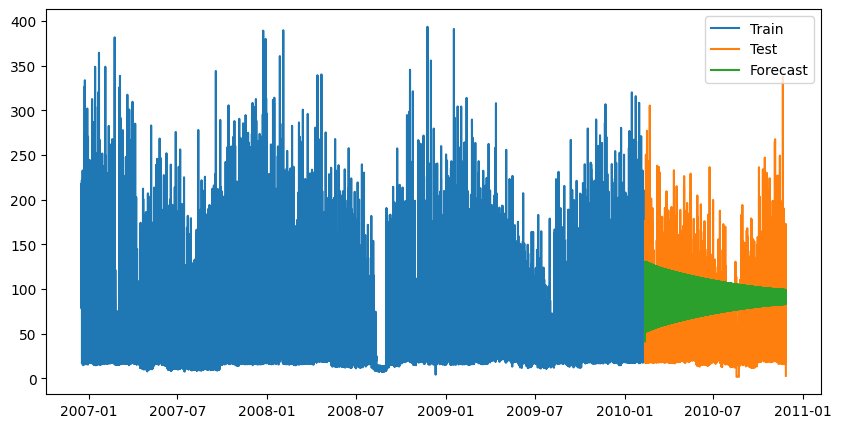

In [132]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(train_hourly.index, train_hourly['total_real_power'], label='Train')
plt.plot(test_hourly.index, test_hourly['total_real_power'], label='Test')
plt.plot(test_hourly.index, pred_hourly, label='Forecast')
plt.legend()
plt.show()